In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
from google.colab import drive

class SPOTDataLoader(Dataset):
    def __init__(self, root_dir, labels_file, transform=None):
        print("Initializing SPOTDataLoader...")
        self.root_dir = root_dir
        self.transform = transform
        self.labels = np.load(labels_file)
        # print(f"Loaded labels from {labels_file} with shape: {self.labels.shape}")

        if torch.cuda.is_available():
            self.cuda = True
            # print("CUDA is available. Using GPU.")
        else:
            self.cuda = False
            # print("CUDA is not available. Using CPU.")

    def __len__(self):
        length = self.labels.shape[0]
        # print(f"Dataset length: {length}")
        return length

    def __getitem__(self, idx):
        # print(f"\nFetching data for index: {idx}")
        folder_name = format(idx, '05d')
        folder_path = os.path.join(self.root_dir, folder_name)
        # print(f"Constructed folder path: {folder_path}")

        input_images = []
        for i in range(4):
            input_image_path = os.path.join(folder_path, f"{i}.jpg")
            # print(f"Loading input image {i} from: {input_image_path}")
            image = Image.open(input_image_path).convert('RGB')
            # print(f"Loaded input image {i} with size: {image.size}")
            if self.transform:
                image = self.transform(image)
                #print(f"Applied transform to input image {i}.")
            input_images.append(image)

        goal_images = []
        for i in range(1):
            goal_image_path = os.path.join(folder_path, f"goal_{i}.jpg")
            # print(f"Loading goal image {i} from: {goal_image_path}")
            image = Image.open(goal_image_path).convert('RGB')
            # print(f"Loaded goal image {i} with size: {image.size}")
            if self.transform:
                image = self.transform(image)
                # print(f"Applied transform to goal image {i}.")
            goal_images.append(image)

        label = self.labels[idx]
        # print(f"Label for index {idx}: {label}")

        if self.cuda:
            input_images_tensor = torch.stack(input_images, dim=0).cuda()
            goal_images_tensor = torch.stack(goal_images, dim=0).cuda()
            label_tensor = torch.tensor(label).cuda()
            # print("Moved input images, goal images, and label tensor to GPU.")
        else:
            input_images_tensor = torch.stack(input_images, dim=0)
            goal_images_tensor = torch.stack(goal_images, dim=0)
            label_tensor = torch.tensor(label)
            # print("Using CPU tensors for input images, goal images, and label tensor.")

        # print(f"Input images tensor shape: {input_images_tensor.shape}")
        # print(f"Goal images tensor shape: {goal_images_tensor.shape}")
        # print(f"Label tensor: {label_tensor}")

        return input_images_tensor, goal_images_tensor, label_tensor

In [ ]:
# REMOVED DROPOUT LAYERS FOR OVERFITTING

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18

class CrossAttentionBlock(nn.Module):
    def __init__(self, embed_dim, num_heads=8):
        super(CrossAttentionBlock, self).__init__()
        self.mha = nn.MultiheadAttention(embed_dim, num_heads)

    def forward(self, query, key_value):
        # query and key_value: (B, C, H, W)
        B, C, H, W = query.shape

        # (H*W, B, C)
        query_flat = query.view(B, C, -1).permute(2, 0, 1)

        key_value_flat = key_value.view(B, C, -1).permute(2, 0, 1)
        attn_output, _ = self.mha(query_flat, key_value_flat, key_value_flat)

        # (B, C, H, W)
        attn_output = attn_output.permute(1, 2, 0).view(B, C, H, W)
        return attn_output

class SharedResNet18MLP(nn.Module):
    def __init__(self):
        super(SharedResNet18MLP, self).__init__()
        # Shared ResNet18 trunk (excluding the last 2 layers)
        base_resnet = resnet18(weights=None)
        self.shared_trunk = nn.Sequential(*list(base_resnet.children())[:-2])
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        num_trunk_channels = 512
        self.num_cameras = 4

        # Camera-specific heads for current images
        self.current_heads = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(num_trunk_channels, num_trunk_channels, kernel_size=1),
                nn.ReLU(inplace=True)
            ) for _ in range(self.num_cameras)
        ])

        # Camera-specific heads for the goal image (each camera gets its own version)
        self.goal_heads = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(num_trunk_channels, num_trunk_channels, kernel_size=1),
                nn.ReLU(inplace=True)
            ) for _ in range(self.num_cameras)
        ])

        # Cross-attention block shared across cameras
        self.cross_attention = CrossAttentionBlock(embed_dim=num_trunk_channels, num_heads=8)

        # Fully connected layers.
        # Input feature dimension: 4 cameras * 2 (current + goal) * 512 = 4096.
        self.fc_layer1 = nn.Sequential(
            nn.Linear(4096, 1024),
            nn.ReLU()
        )
        self.fc_layer2 = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.ReLU()
        )
        self.fc_layer3 = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.ReLU()
        )
        self.fc_layer4 = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.ReLU()
        )
        # Final output layer produces 3 regression outputs.
        self.fc_layer5 = nn.Linear(1024, 3)

    def forward(self, current_images, goal_image):
        batch_size = current_images.size(0)
        current_features_list = []
        goal_features_list = []

        # Processing the goal image once through the shared trunk.
        goal_trunk_feat = self.shared_trunk(goal_image)  # (B, 512, H', W')

        for cam_idx in range(self.num_cameras):
            # Processing current image for camera cam_idx.
            curr = current_images[:, cam_idx, :, :, :]  # (B, C, H, W)
            curr_feat = self.shared_trunk(curr)         # (B, 512, H', W')
            curr_feat = self.current_heads[cam_idx](curr_feat)

            # Processing the same goal image for this camera.
            goal_feat = self.goal_heads[cam_idx](goal_trunk_feat)

            # Applying cross-attention in both directions.
            curr_attended = curr_feat + self.cross_attention(curr_feat, goal_feat)
            goal_attended = goal_feat + self.cross_attention(goal_feat, curr_feat)

            # Global pooling.
            curr_pooled = self.global_pool(curr_attended).view(batch_size, -1)  # (B, 512)
            goal_pooled = self.global_pool(goal_attended).view(batch_size, -1)  # (B, 512)

            current_features_list.append(curr_pooled)
            goal_features_list.append(goal_pooled)

        # Concatenating features from all cameras.
        current_features = torch.cat(current_features_list, dim=1)  # (B, 4*512 = 2048)
        goal_features = torch.cat(goal_features_list, dim=1)        # (B, 2048)
        features = torch.cat([current_features, goal_features], dim=1)  # (B, 4096)

        # Fully connected layers.
        x = self.fc_layer1(features)
        x = self.fc_layer2(x)
        x = self.fc_layer3(x)
        x = self.fc_layer4(x)
        output = self.fc_layer5(x)  # (B, 3)
        return output


In [ ]:
import matplotlib.pyplot as plt
import os

WEIGHT_SAVING_STEP = 10
DPI = 120
FIGURE_SIZE_PIXEL = [2490, 1490]
FIGURE_SIZE = [fsp / DPI for fsp in FIGURE_SIZE_PIXEL]

def plot_graph(training_losses, train_accuracies, figure_path=None, start_plot=0, end_plot=None):
    if end_plot is None or end_plot > len(training_losses):
        end_plot = len(training_losses)

    epochs = range(start_plot + 1, end_plot + 1)

    # =====Training Loss =====
    plt.figure(figsize=FIGURE_SIZE, dpi=DPI)
    plt.scatter(epochs, training_losses[start_plot:end_plot], color='blue', label='Training Loss')
    plt.plot(epochs, training_losses[start_plot:end_plot], color='cyan', linestyle='-', label='Loss Trend')
    plt.title("Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss (scaled)")
    plt.legend()

    lowest_loss = min(training_losses[start_plot:end_plot])
    for i, loss in enumerate(training_losses[start_plot:end_plot], start=start_plot+1):
        if (i % WEIGHT_SAVING_STEP == 0) or (i == end_plot):
            plt.annotate(str(round(loss, 6)), xy=(i, loss))

    plt.text(0, plt.gca().get_ylim()[1], f'Lowest Loss: {lowest_loss:.6f}')

    if figure_path is not None:
        plt.savefig(os.path.join(figure_path, 'Training_loss.png'))
    plt.show()

    # ===== Training Accuracy =====
    plt.figure(figsize=FIGURE_SIZE, dpi=DPI)
    plt.plot(epochs, train_accuracies[start_plot:end_plot], color='green', linestyle='-', marker='o',
             label='Training Accuracy')
    plt.title("Training Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()

    for i, acc in enumerate(train_accuracies[start_plot:end_plot], start=start_plot+1):
        if (i % WEIGHT_SAVING_STEP == 0) or (i == end_plot):
            plt.annotate(f"{round(acc, 2)}", xy=(i, acc))

    if figure_path is not None:
        plt.savefig(os.path.join(figure_path, 'Training_accuracy.png'))
    plt.show()


In [ ]:
import os
import torch
import numpy as np
from torch.utils.data import DataLoader
from torchvision import transforms

# === Paths ===
SPLIT_DATA_PATH = '/content/drive/MyDrive/Spot_IL/Real Test Data Lab'
LABEL_PATH = os.path.join(SPLIT_DATA_PATH, 'train/labels.npy')
TRAIN_PATH = os.path.join(SPLIT_DATA_PATH, 'train')

WEIGHT_PATH = os.path.join(SPLIT_DATA_PATH, 'weights/resnet18_mlp5')
os.makedirs(WEIGHT_PATH, exist_ok=True)

FIGURE_PATH = os.path.join(SPLIT_DATA_PATH, 'Results/resnet18_mlp5')
os.makedirs(FIGURE_PATH, exist_ok=True)

# === Data Transforms ===
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# === Device Setup ===
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {DEVICE}')

# === Dataset (No Split) ===
full_dataset = SPOTDataLoader(
    root_dir=TRAIN_PATH,
    labels_file=LABEL_PATH,
    transform=data_transforms
)

# Using entire dataset for training
train_dataset = full_dataset
print(f'Training samples: {len(train_dataset)}')

BATCH_SIZE = 2
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# === Hyperparameters & Loss ===
LEARNING_RATE = 1e-4
NUM_EPOCHS = 300
LOSS_SCALE = 1e3
TOLERANCE = 1e-1
loss_fn = torch.nn.MSELoss()

# === Model, Optimizer ===
model = SharedResNet18MLP().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# === Training Loop ===
training_losses = []
train_accuracies = []

for epoch in range(1, NUM_EPOCHS + 1):
    # --- Training ---
    model.train()
    running_loss = 0.0
    for current_images, goal_images, labels in train_dataloader:
        goal_images = goal_images.squeeze(1)  # (B, 1, C, H, W) -> (B, C, H, W)
        current_images = current_images.to(DEVICE)
        goal_images = goal_images.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        output = model(current_images, goal_images)  # (B, 3)
        loss = loss_fn(output, labels.float()) * LOSS_SCALE
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_dataloader)
    training_losses.append(epoch_loss)
    print(f"Epoch {epoch}/{NUM_EPOCHS} -- Training Loss: {epoch_loss:.6f}")

    # --- Training Accuracy ---
    model.eval()
    train_correct = 0
    train_total = 0
    with torch.no_grad():
        for current_images, goal_images, labels in train_dataloader:
            goal_images = goal_images.squeeze(1)
            current_images = current_images.to(DEVICE)
            goal_images = goal_images.to(DEVICE)
            labels = labels.to(DEVICE)

            output = model(current_images, goal_images)  # (B, 3)
            for i in range(output.size(0)):
                error = torch.norm(output[i] - labels[i].float(), p=2).item()
                train_total += 1
                if error < TOLERANCE:
                    train_correct += 1

    train_accuracy = (train_correct / train_total) * 100
    train_accuracies.append(train_accuracy)
    print(f"Epoch {epoch}/{NUM_EPOCHS} -- Training Accuracy: {train_accuracy:.2f}%")

    # --- Weights Every 10 Epochs ---
    if epoch % 10 == 0:
        weight_file = os.path.join(WEIGHT_PATH, f'epoch_{epoch}.pth')
        torch.save(model.state_dict(), weight_file)
        print(f"Weights saved at epoch {epoch}")

# === Final Model ===
final_weight_file = os.path.join(WEIGHT_PATH, f'final_epoch_{NUM_EPOCHS}.pth')
torch.save(model.state_dict(), final_weight_file)
print("Training complete. Final model saved.")

Using device: cuda
Initializing SPOTDataLoader...
Training samples: 15
Epoch 1/300 -- Training Loss: 271.872774
Epoch 1/300 -- Training Accuracy: 0.00%
Epoch 2/300 -- Training Loss: 171.918144
Epoch 2/300 -- Training Accuracy: 0.00%
Epoch 3/300 -- Training Loss: 174.530385
Epoch 3/300 -- Training Accuracy: 0.00%
Epoch 4/300 -- Training Loss: 126.064482
Epoch 4/300 -- Training Accuracy: 0.00%
Epoch 5/300 -- Training Loss: 180.848129
Epoch 5/300 -- Training Accuracy: 0.00%
Epoch 6/300 -- Training Loss: 225.842381
Epoch 6/300 -- Training Accuracy: 0.00%
Epoch 7/300 -- Training Loss: 162.569987
Epoch 7/300 -- Training Accuracy: 0.00%
Epoch 8/300 -- Training Loss: 111.207036
Epoch 8/300 -- Training Accuracy: 0.00%
Epoch 9/300 -- Training Loss: 109.119002
Epoch 9/300 -- Training Accuracy: 0.00%
Epoch 10/300 -- Training Loss: 62.247077
Epoch 10/300 -- Training Accuracy: 6.67%
Weights saved at epoch 10
Epoch 11/300 -- Training Loss: 78.724463
Epoch 11/300 -- Training Accuracy: 26.67%
Epoch 12/

TypeError: can only concatenate str (not "int") to str

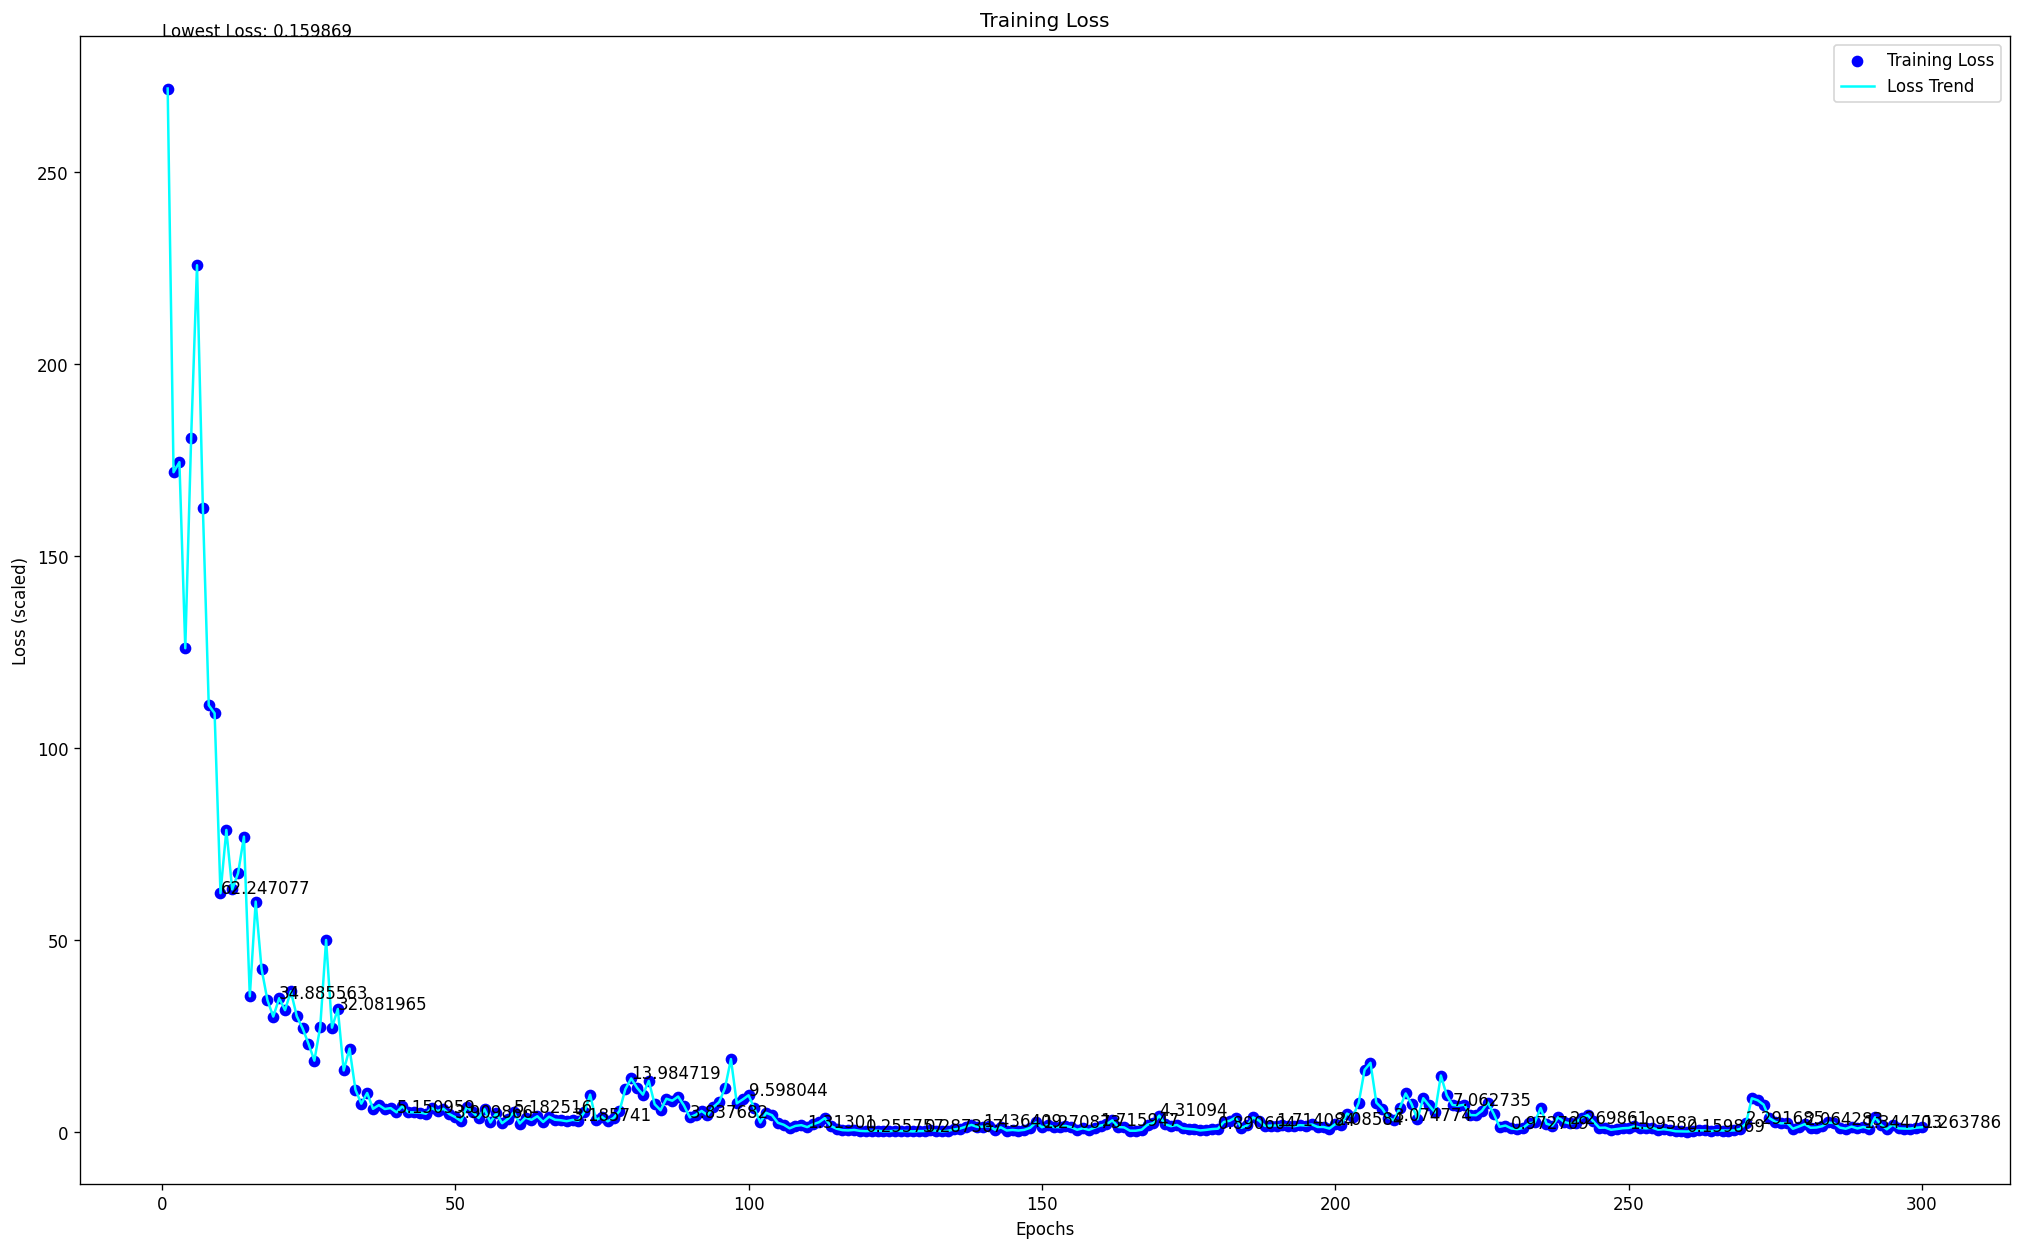

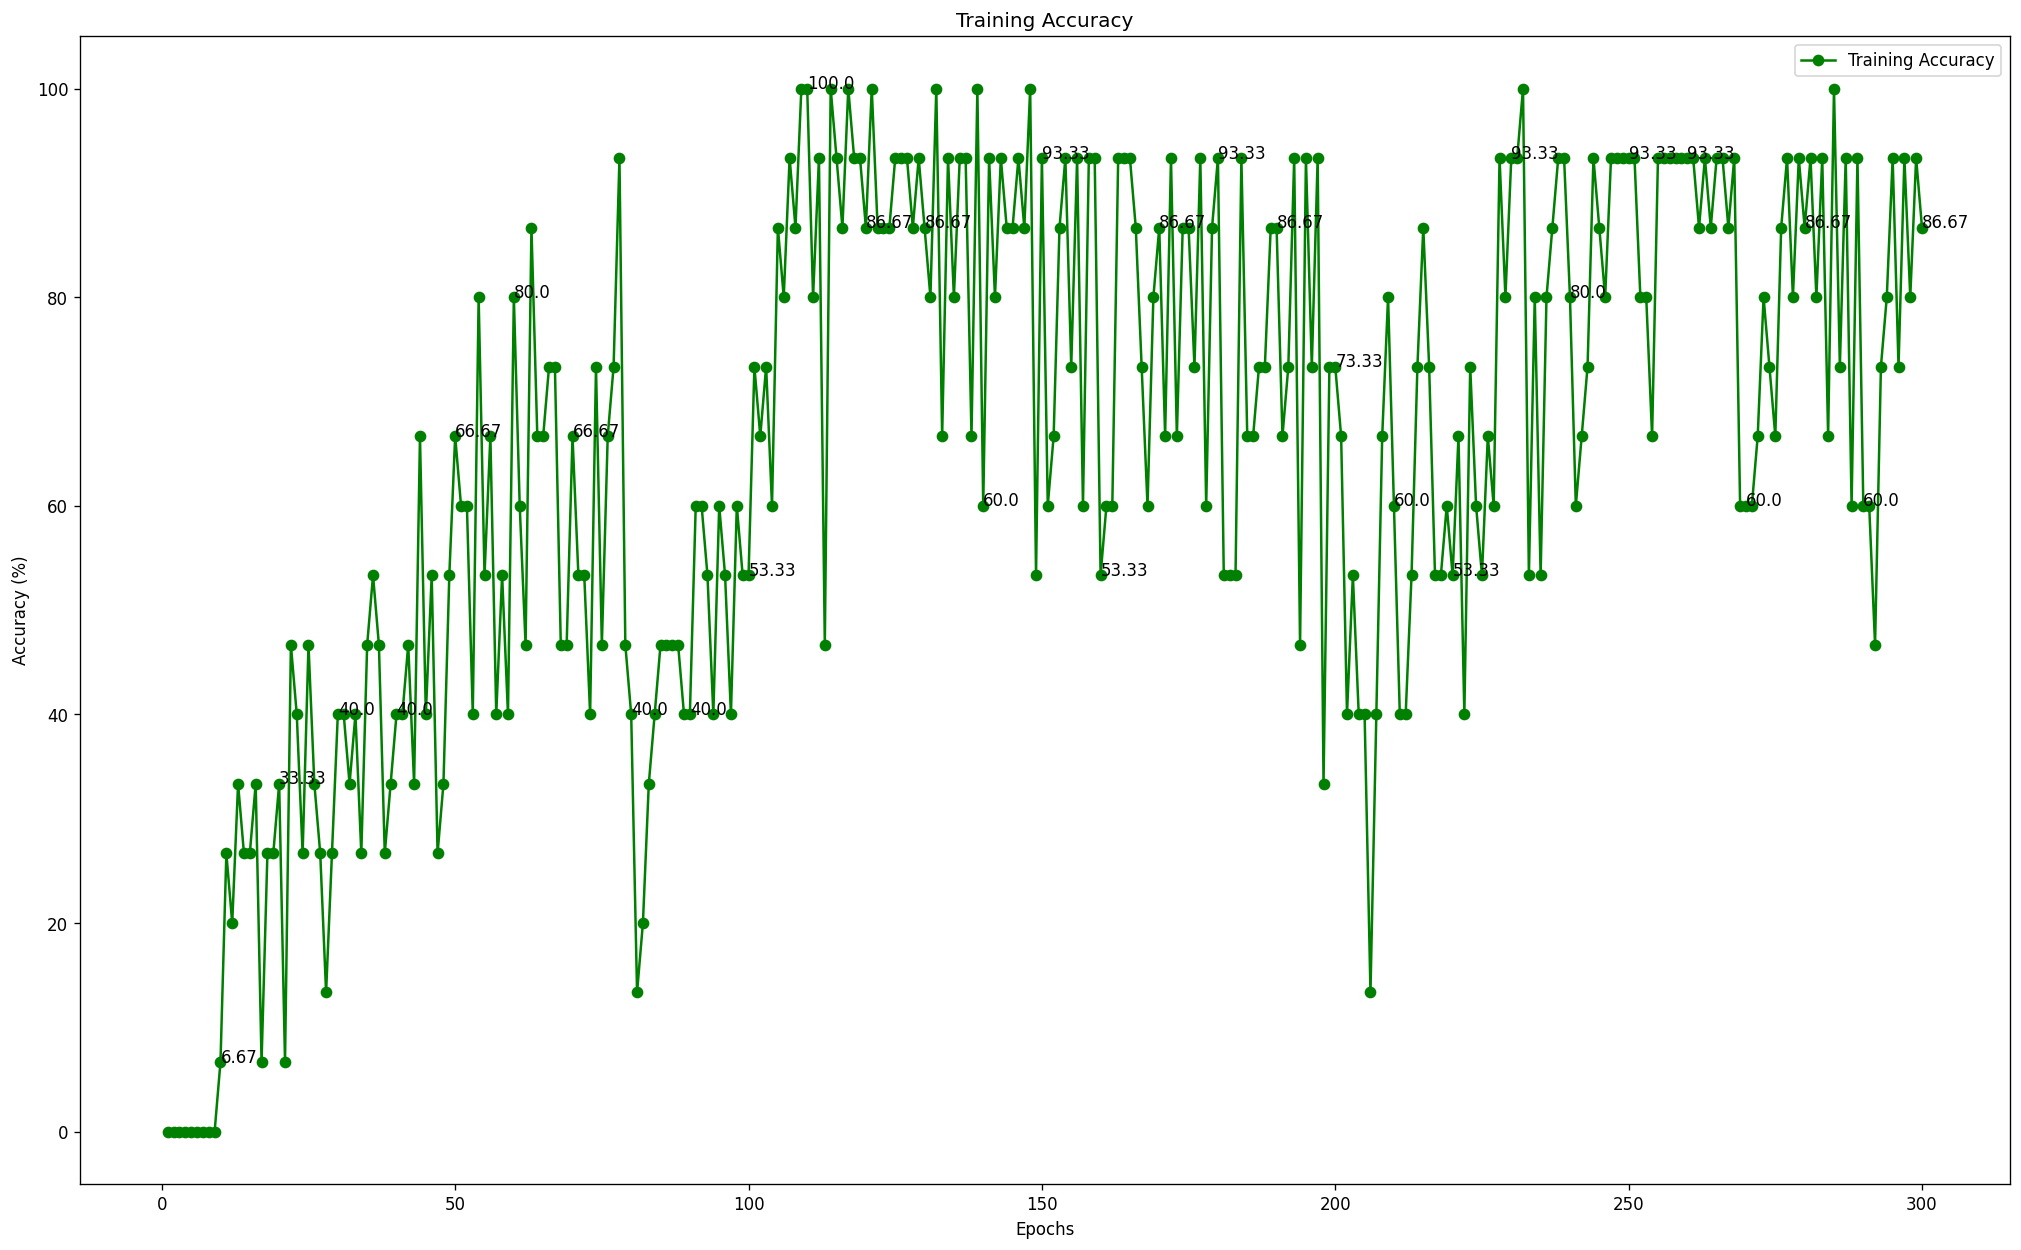

In [ ]:
# === Plot Training Curves (Optional) ===
# If your plot_graph function expects validation accuracies, remove or adapt that argument:
plot_graph(training_losses, train_accuracies, FIGURE_PATH, start_plot=0, end_plot=NUM_EPOCHS)